In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
import math

In [2]:
data_x0 = np.loadtxt('../Data/nonlinear_vectorfield_data_x0.txt')
data_x1 = np.loadtxt('../Data/nonlinear_vectorfield_data_x1.txt')

In [3]:
x0x, x0y = data_x0.T
x1x, x1y = data_x1.T

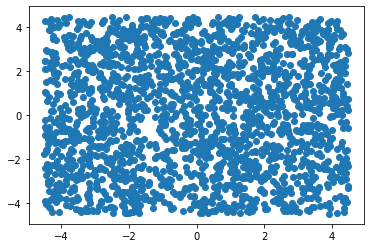

In [4]:
plt.scatter(x0x,x0y)
plt.show()

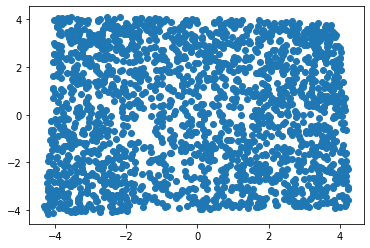

In [5]:
plt.scatter(x1x,x1y)
plt.show()

In [6]:
xd = x1x-x0x
yd = x1y-x0y

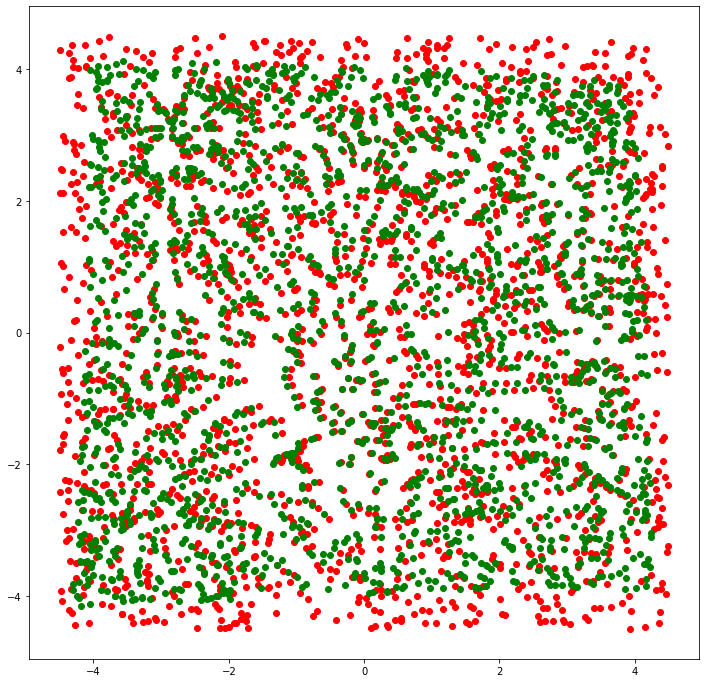

In [7]:
fig = plt.figure(figsize=(12,12))

plt.scatter(x0x,x0y,color='r')
plt.scatter(x1x,x1y,color='g')
plt.show()

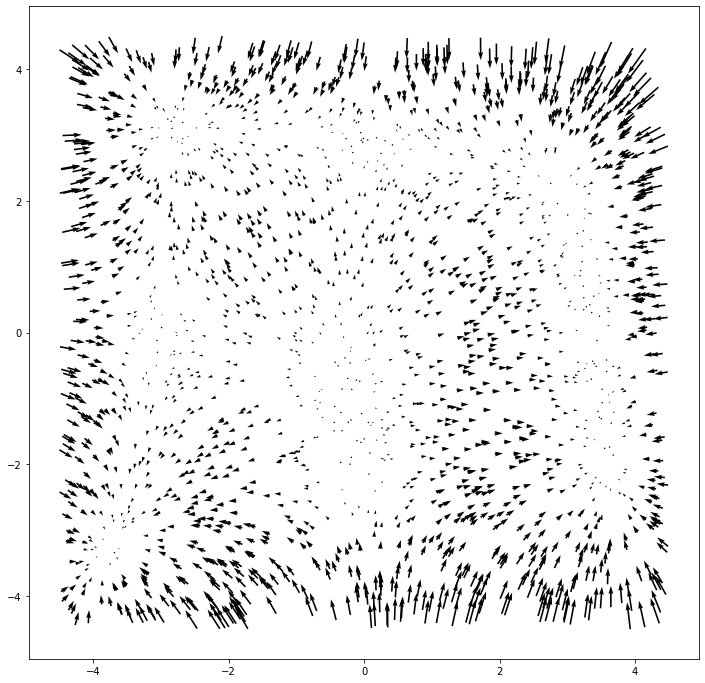

In [8]:
fig = plt.figure(figsize=(12,12))

plt.quiver(x0x, x0y, xd, yd)
plt.show()

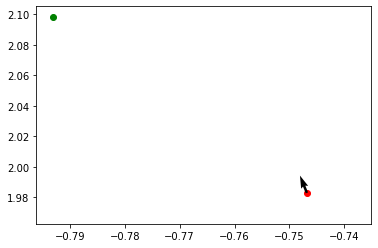

In [9]:
plt.scatter(x0x[0], x0y[0], color='r')
plt.scatter(x1x[0], x1y[0], color='g')
plt.quiver(x0x[0], x0y[0], xd[0], yd[0])
plt.show()

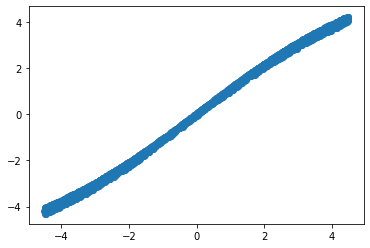

In [10]:
plt.scatter(x0x,x1x)
plt.show()

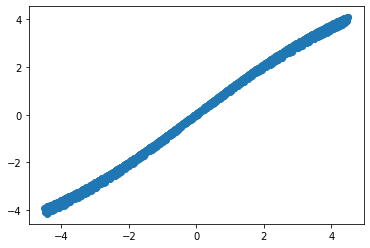

In [11]:
plt.scatter(x0y,x1y)
plt.show()

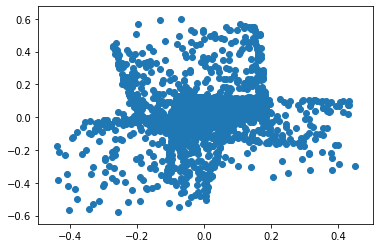

In [12]:
plt.scatter(xd,yd)
plt.show()

In [13]:
def rbf(x, xl, epsilon, plot=True):
    r = np.exp(-(x-xl)**2 / (epsilon**2))
    if plot:
        plt.plot(x, r, '.')
    return r

In [14]:
def plot_radials(x, coef, l=10, epsilon=1, plot=False):

    points = []

    final = np.zeros_like(x)

    for i in range(l):
        points.append(np.min(x) + (i*(np.max(x)-np.min(x))/l))

    for i in range(l):
        xl = np.ones(len(x))*points[i]
            
        r = np.exp(-(x-xl)**2 / (epsilon**2))*coef[i]
        final = final + r
        if(plot):
            plt.plot(x, r, '.')
        
    return final/l

In [15]:
def least_squares(x, y):
    a = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq(a, y, rcond=None)[0]

In [16]:
def least_squares_radial(x, y, l=10, epsilon=1, plot=True):

    if plot:
        fig = plt.figure(figsize=(12,12))
    
    points = []
    results = []
    
    for i in range(l):
        points.append(np.min(x) + (i*(np.max(x)-np.min(x))/l))
                          
    for i in range(l):
        xl = np.ones(len(x))*points[i]
        if plot:
            results.append(rbf(x, xl, epsilon))
        else:
            results.append(rbf(x, xl, epsilon, plot=False))
        
    results = np.array(results)
            
    if plot:
        plt.show()
        
    c = np.vstack([results, np.ones(results.shape)]).T
    
    return np.linalg.lstsq(c, y, rcond=None)[0]

In [17]:
def approximate(x0x, x0y, xd, yd):

    mx, cx = least_squares(x0x, xd)
    my, cy = least_squares(x0y, yd)

    fx = np.polyval([mx, cx], x0x)
    fy = np.polyval([my, cy], x0y)

    return mx, my, cx, cy, fx, fy

In [18]:
def approximate_radial(x0x, x0y, xd, yd, l=10, epsilon=1, plot=False):

    coef_x = least_squares_radial(x0x, xd, epsilon=epsilon, l=l, plot=plot)
    coef_y = least_squares_radial(x0y, yd, epsilon=epsilon, l=l, plot=plot)
    
    if plot:
        fig = plt.figure(figsize=(12,12))
        
    fx = plot_radials(x0x, coef_x, l=l, plot=plot)
    plt.plot(x0x, xd, '.k')
    
    if plot:
        fig = plt.figure(figsize=(12,12))
        
    fy = plot_radials(x0y, coef_y, l=l, plot=plot)
    plt.plot(x0y, yd, '.k')
    
    if plot:
        fig = plt.figure(figsize=(12,12))
    
    plt.plot(x0x, fx, '.r')
    plt.plot(x0x, xd, '.g')
    
    if plot:
        fig = plt.figure(figsize=(12,12))
    
        plt.plot(x0y, fy, '.r')
        plt.plot(x0y, yd, '.g')

    return fx, fy

In [19]:
def evaluate(mx, my, x0x, x0y, t=1):
    
    ev_x = np.polyval([mx, cx], x0x)*t
    ep_x = ev_x + x0x

    ev_y = np.polyval([my, cy], x0y)*t
    ep_y = ev_y + x0y
    
    return ep_x, ep_y

In [20]:
def evaluate_radial(x0x, x0y, fx, fy, t=1, plot=True):
    
    ev_x = fx*t
    ep_x = ev_x + x0x

    ev_y = fy*t
    ep_y = ev_y + x0y
    
    return ep_x, ep_y

In [21]:
def mse(x0x, x0y, mx, my, cx, cy, t=1):

    ep_x, ep_y = evaluate(mx, my, x0x, x0y, t)

    return np.mean(np.sqrt(np.square(ep_x - x1x) + np.square(ep_y - x1y))) 

In [22]:
def mse_radial(x0x, x0y, fx, fy, t=1, plot=True):

    ep_x, ep_y = evaluate_radial(x0x, x0y, fx, fy, t=t)
    
    if plot:
        
        fig = plt.figure(figsize=(12,12))
        
        plt.plot(ep_x, '.r')
        plt.plot(x1x, '.g')
        plt.show()

        fig = plt.figure(figsize=(12,12))

        plt.plot(ep_y, '.r')
        plt.plot(x1y, '.g')
        plt.show()

    return np.mean(np.sqrt(np.square(ep_x - x1x) + np.square(ep_y - x1y))) 

In [23]:
mx, my, cx, cy, fx, fy = approximate(x0x, x0y, xd, yd)
print(mse(x0x, x0y, mx, my, cx, cy))

0.17494129240216688


In [24]:
dt = 0.001

losses = []

for i in range(len(x0x)):
    
    x = x0x[i] 
    y = x0y[i]
    
    xk = x1x[i] 
    yk = x1y[i]
    
    min_loss = 1000000
    min_loss_t = -1
    
    for t in range(100):
        
        ep_x, ep_y = evaluate(mx, my, x, y, dt)
        loss = np.mean(np.sqrt(np.square(ep_x - xk) + np.square(ep_y - yk))) 
        x = ep_x
        y = ep_y
        
        if loss < min_loss:
            min_loss = loss
            min_loss_t = t
    
    losses.append([min_loss, min_loss_t])

result = np.mean(losses, axis=0)

loss_avg = result[0]
t_avg = np.round(result[1]*dt, 3)
steps_avg = np.round(result[1])

print(steps_avg)

53.0


In [25]:
losses = []

for i in range(len(x0x)):
    
    x = x0x[i] 
    y = x0y[i]
    
    ep_x = -1
    ep_y = -1
    
    xk = x1x[i] 
    yk = x1y[i]
    
    for t in range(int(steps_avg)):
    
        ep_x, ep_y = evaluate(mx, my, x, y, dt)
        loss = np.mean(np.sqrt(np.square(ep_x - xk) + np.square(ep_y - yk))) 
        x = ep_x
        y = ep_y

    losses.append(np.mean(np.sqrt(np.square(ep_x - xk) + np.square(ep_y - yk))))
    
mse = np.mean(losses)

print(mse)

0.18455361771774256


0.13611618727633437  |  0.005


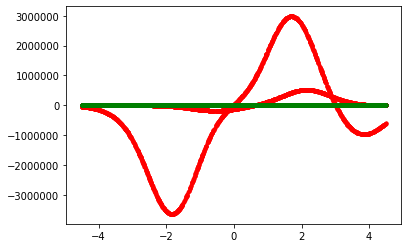

In [26]:
er = np.linspace(0.001, 0.1, 100)

min_loss = 1000000
min_epsilon = -1

for e in er:
    fx, fy = approximate_radial(x0x, x0y, xd, yd, epsilon=e, l=100, plot=False)
    loss = mse_radial(x0x, x0y, fx, fy, plot=False)
    
    if loss < min_loss:
        min_loss = loss
        min_epsilon = e

print(min_loss, " | ", min_epsilon)


0.13611618727633437


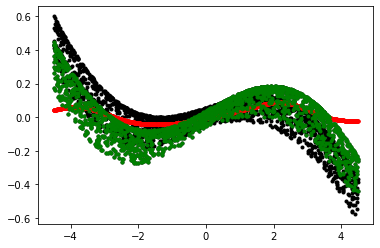

In [27]:
fx, fy = approximate_radial(x0x, x0y, xd, yd, epsilon=0.005, l=100, plot=False)
print(mse_radial(x0x, x0y, fx, fy, plot=False))

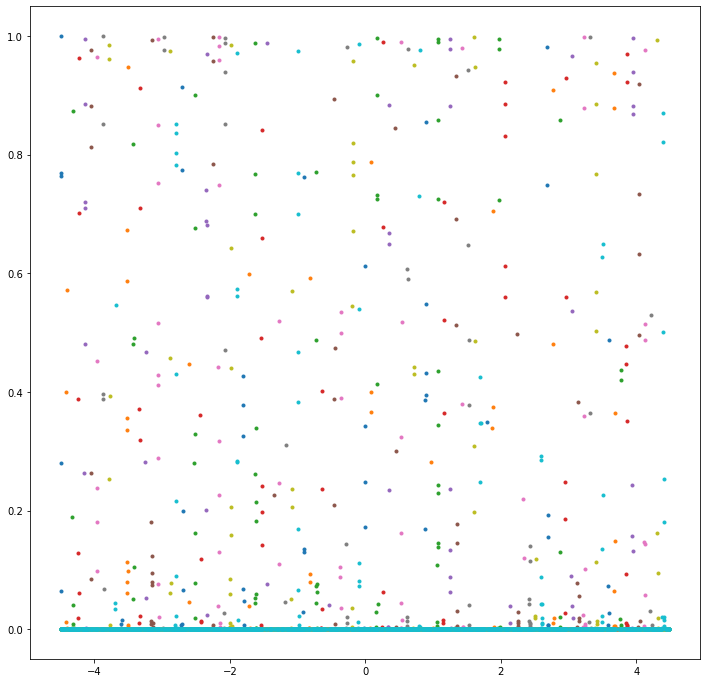

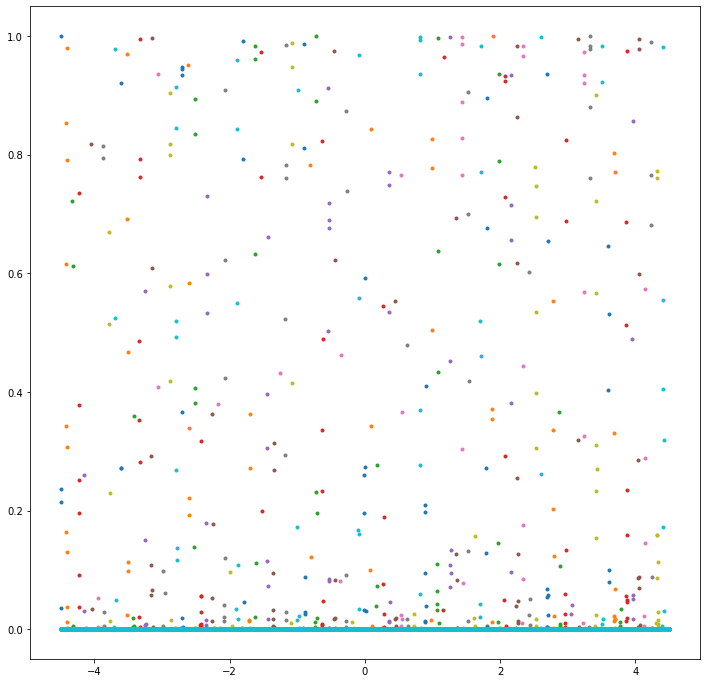

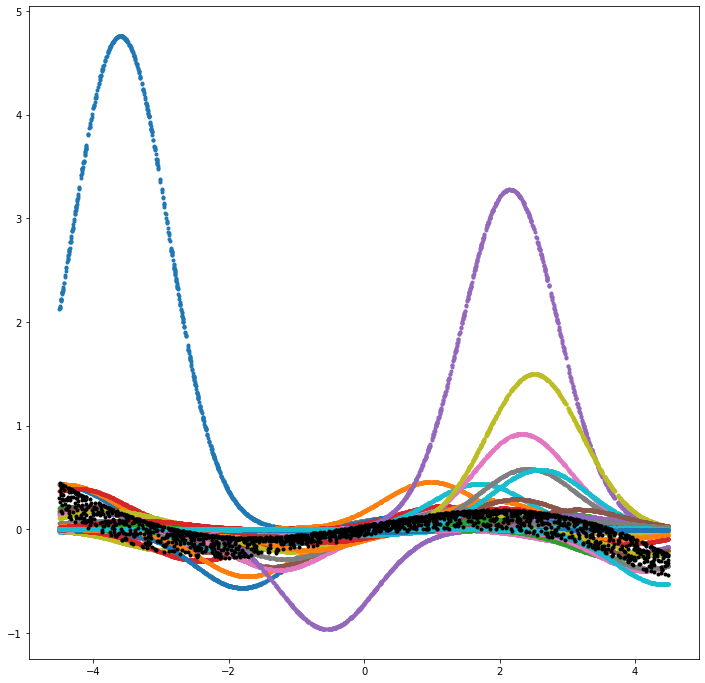

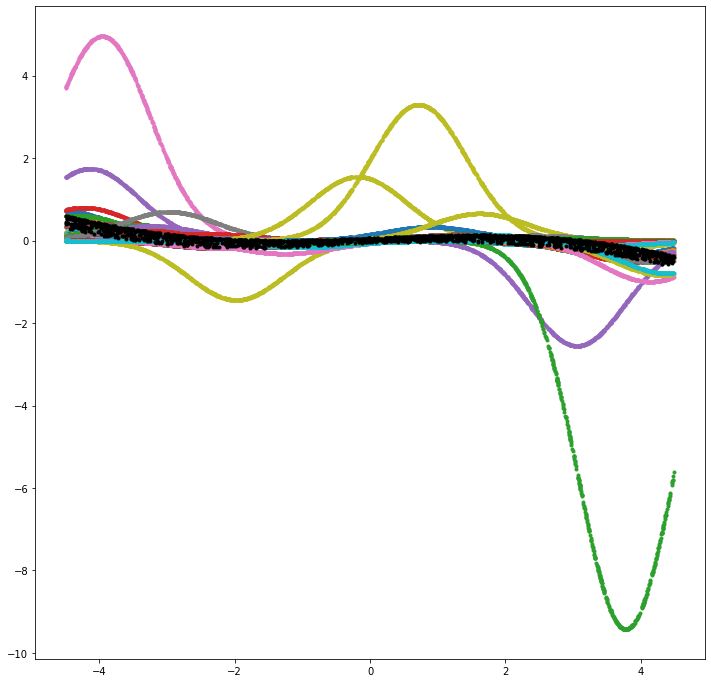

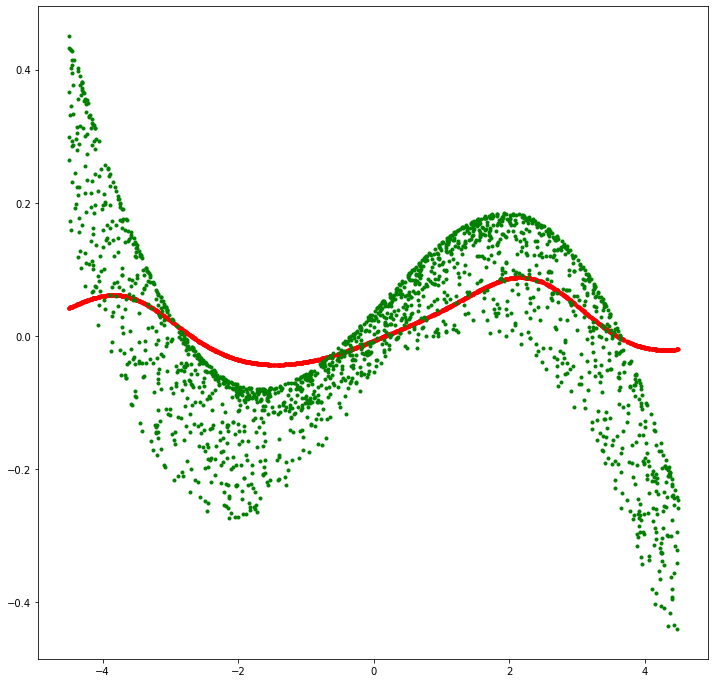

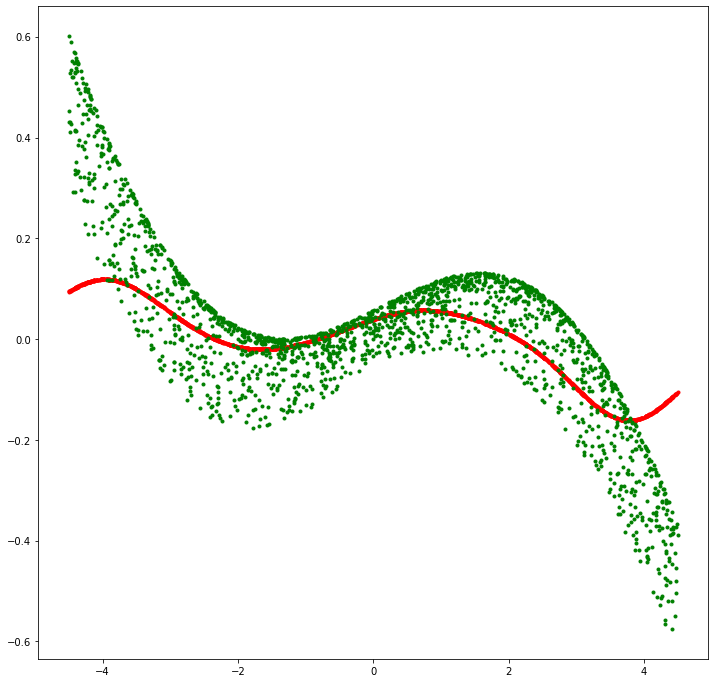

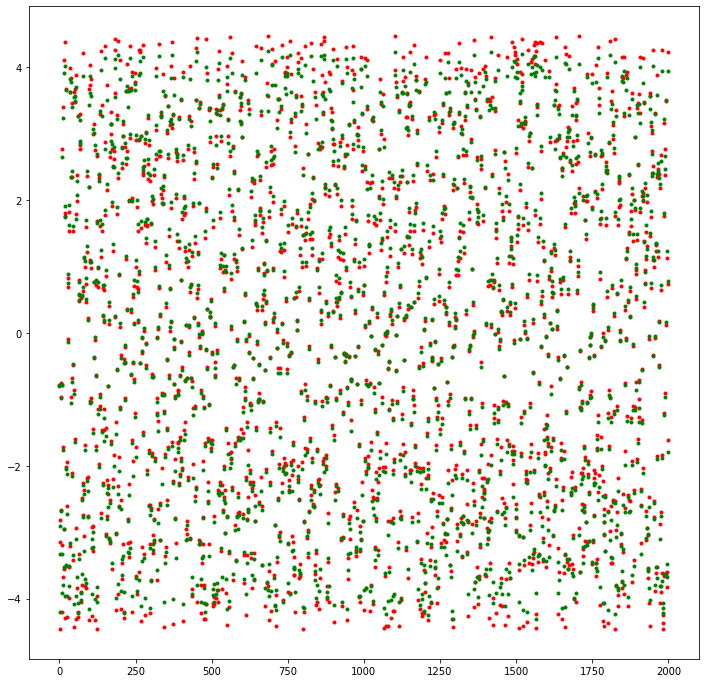

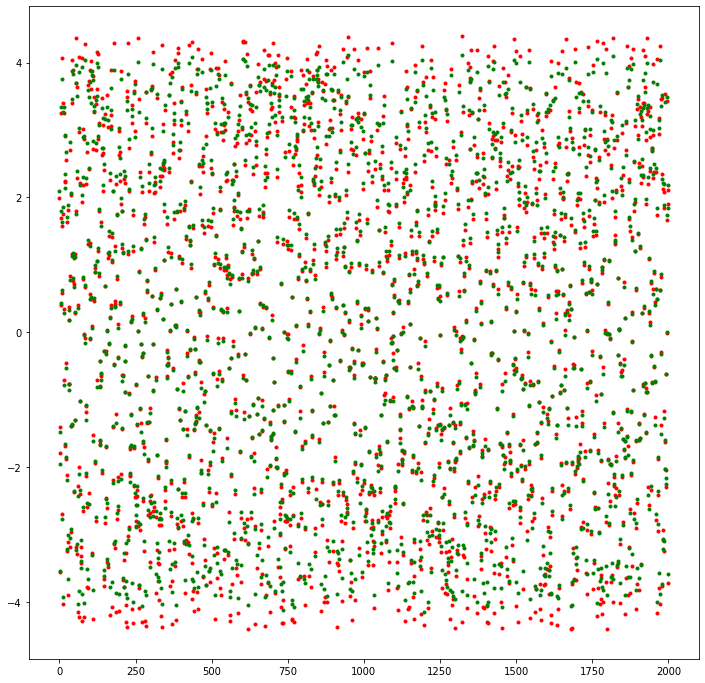

0.13611618727633437


In [28]:
fx, fy = approximate_radial(x0x, x0y, xd, yd, epsilon=min_epsilon, l=100, plot=True)
print(mse_radial(x0x, x0y, fx, fy, plot=True))

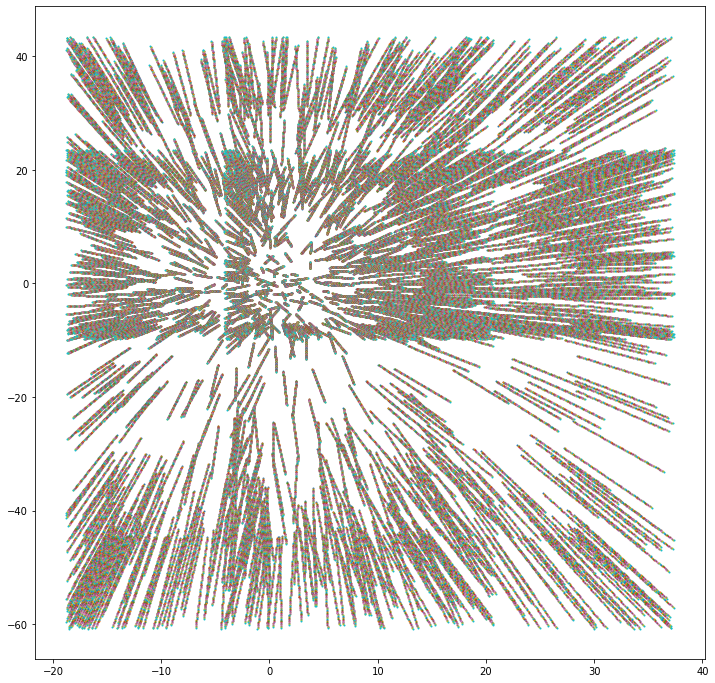

In [36]:
tt = np.linspace(1, 100, 100)

fig = plt.figure(figsize=(12,12))

points_x = []
points_y = []

for i in tt:
    
    ep_x, ep_y = evaluate_radial(x0x, x0y, fx, fy, t=1, plot=False)
    
    x0x = ep_x
    x0y = ep_y
    
    plt.scatter(ep_x, ep_y, marker='o', s=1)
    
plt.show()